In [ ]:
#i realized that i hadn't made a linear regression model uptill now so here's one on electricity costs

In [24]:
#imports
import torch
from torch.utils.data import TensorDataset,DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [25]:
#loading and normalizing data
df = pd.read_csv('electricity_cost_dataset.csv')

le = LabelEncoder()
input_scaler = StandardScaler()
output_scaler = StandardScaler()

df['structure type'] = le.fit_transform(df['structure type'])

x = np.array(df.drop(columns=['electricity cost']))
y = np.array(df['electricity cost'])

X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size=0.8, random_state=42, shuffle=True)

X_train = input_scaler.fit_transform(X_train)
X_test = input_scaler.transform(X_test)

Y_train = output_scaler.fit_transform(Y_train.reshape(-1,1))
Y_test = output_scaler.transform(Y_test.reshape(-1,1))

In [26]:
#making dataloaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype = torch.float32), torch.tensor(Y_train,dtype = torch.float32))
train_loader = DataLoader(train_dataset, shuffle=True, batch_size = 32)

test_dataset = TensorDataset(torch.tensor(X_test,dtype = torch.float32), torch.tensor(Y_test,dtype = torch.float32))
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

In [27]:
#model defination
class ann(nn.Module):

  def __init__(self, input_dim):
    super().__init__()

    self.fc1 = nn.Linear(input_dim, 12)
    self.fc2 = nn.Linear(12,24)
    self.fc3 = nn.Linear(24,12)
    self.fc4 = nn.Linear(12,1)

  def forward(self,X):

    out = F.relu(self.fc1(X))
    out = F.relu(self.fc2(out))
    out = F.relu(self.fc3(out))

    return self.fc4(out)

#model init
model = ann(X_train.shape[1])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#hyperparameters
n_epochs = 30
learning_rate = 0.001
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

For Epoch 10: Loss = 0.037507209807634355
For Epoch 20: Loss = 0.034281062185764315
For Epoch 30: Loss = 0.03399113023281097


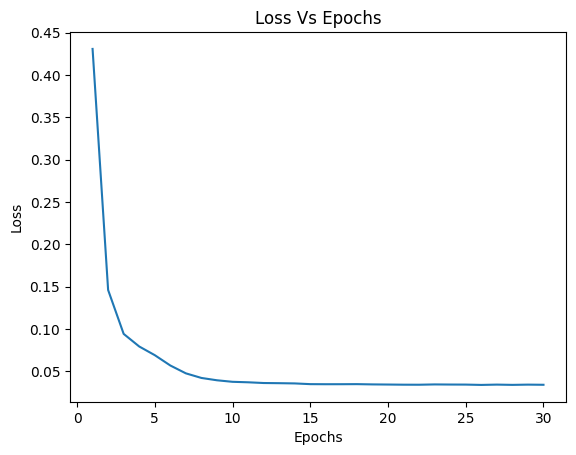

In [28]:
#training loop
graph = {}

for epoch in range(n_epochs):

  total_loss = 0

  for batch_x,batch_y in train_loader:

    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    y_hat = model(batch_x)

    l = loss(y_hat,batch_y)

    l.backward()

    optimizer.step()

    optimizer.zero_grad()

    total_loss += l.item()*batch_x.size(0)

  avg_loss = total_loss / len(train_loader.dataset)

  if(epoch+1)%10==0:
    print(f'For Epoch {epoch+1}: Loss = {avg_loss}')

  graph[epoch+1] = avg_loss

plt.title('Loss Vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(graph.keys(), graph.values())

In [29]:
#evaluating the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        y_true.append(batch_y.cpu())
        y_pred.append(outputs.cpu())

y_true = torch.cat(y_true).squeeze()
y_pred = torch.cat(y_pred).squeeze()

y_pred = output_scaler.inverse_transform(y_pred.reshape(-1,1))
y_true = output_scaler.inverse_transform(y_true.reshape(-1,1))

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.2f}, MAE: {mae:.2f}, R² Score: {r2:.2f}')

MSE: 43563.75, MAE: 167.35, R² Score: 0.97


In [30]:
#let's see how standard linear regression compares to an ann

In [31]:
#using sklearn to implement linear regression
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train,Y_train)

LinearRegression()

In [32]:
#evaluating the model
Y_pred = model.predict(X_test)

Y_pred = output_scaler.inverse_transform(Y_pred)
Y_test_orig = output_scaler.inverse_transform(Y_test)

mse = mean_squared_error(Y_test_orig, Y_pred)
mae = mean_absolute_error(Y_test_orig, Y_pred)
r2 = r2_score(Y_test_orig, Y_pred)

print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R² Score: {r2:.2f}")

MSE: 234848.77, MAE: 374.68, R² Score: 0.81


In [33]:
#it's evident that the ann is performing better, let's try adding polynomial features

In [34]:
#using sklearn to implement polynomial regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

degree = 3
model = Pipeline([
    ('poly', PolynomialFeatures(degree=degree)),
    ('linreg', LinearRegression())
])

model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
Y_pred = output_scaler.inverse_transform(Y_pred)
Y_test_orig = output_scaler.inverse_transform(Y_test)

mse = mean_squared_error(Y_test_orig, Y_pred)
mae = mean_absolute_error(Y_test_orig, Y_pred)
r2 = r2_score(Y_test_orig, Y_pred)

print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R² Score: {r2:.2f}")

MSE: 42610.88, MAE: 164.70, R² Score: 0.97


In [ ]:
#using degrees higher than 4 causes the model to overfit. 3 or 4 seem to be the sweet spot. polynomial regression with a degree of 3 performs
#slightly better than the ann. if i increase it's complexity, i think it'll perform better but it's not worth the hassle, so for this dataset
#polynomial regression wins!